In [172]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
import os
from tensorflow.keras.layers import Conv2D,Conv1D, GlobalAveragePooling2D, Dense, Dropout, DepthwiseConv2D, DepthwiseConv1D

# Imports for visualizations
import shap as shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

In [31]:
# Specify the path to your model and the data directories and parameters

MODEL_DIR = "/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/05_data/computed_data/2025_07_10_plant_classifier_fine_tuned.keras"
TRAIN_DIR = "/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/05_data/original_data/2.1.1 New Plant Diseases/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
VALID_DIR = "/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/05_data/original_data/2.1.1 New Plant Diseases/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

In [32]:
# Load training data from the 'train' directory
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    shuffle=True, 
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Load validation data from the 'valid' directory
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VALID_DIR,
    shuffle=False, 
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Get class names from the dataset object
class_names = train_dataset.class_names
num_classes = len(class_names)
print("Found classes:", class_names)

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.
Found classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold'

In [ ]:
# Load the pre-trained model
model = tf.keras.models.load_model(MODEL_DIR 
,custom_objects={'preprocess_input': preprocess_input})

# Display the model architecture
model.summary()  

# Check input shape compatibility
print(f"Model input shape: {model.input_shape}")
print(f"Number of classes: {num_classes}")  # Should be 38


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 38)             │        48,678 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,126,900 (23.37 MB)

 Trainable params: 1,910,118 (7.29 MB)

 Non-trainable params: 396,544 (1.51 MB)

 Optimizer params: 3,820,238 (14.57 MB)

Model input shape: (None, 224, 224, 3)
Number of classes: 38


In [136]:
# Print all layers of the model used (MobileNetV2)
for i, layer in enumerate(model.layers):
    print(f"{i}: {layer.name} ({layer.__class__.__name__})")

# For MobileNetV2, we typically want the last convolutional layer before the top layers
# This is usually within the MobileNetV2 base model
mobilenet_layers = model.get_layer('mobilenetv2_1.00_224').layers
for i, layer in enumerate(mobilenet_layers):
    if 'Conv' in layer.__class__.__name__:
        print(f"{i}: {layer.name} ({layer.__class__.__name__})")

0: input_layer_1 (InputLayer)
1: sequential (Sequential)
2: mobilenetv2_1.00_224 (Functional)
3: global_average_pooling2d (GlobalAveragePooling2D)
4: dropout (Dropout)
5: dense (Dense)
1: Conv1 (Conv2D)
4: expanded_conv_depthwise (DepthwiseConv2D)
7: expanded_conv_project (Conv2D)
9: block_1_expand (Conv2D)
13: block_1_depthwise (DepthwiseConv2D)
16: block_1_project (Conv2D)
18: block_2_expand (Conv2D)
21: block_2_depthwise (DepthwiseConv2D)
24: block_2_project (Conv2D)
27: block_3_expand (Conv2D)
31: block_3_depthwise (DepthwiseConv2D)
34: block_3_project (Conv2D)
36: block_4_expand (Conv2D)
39: block_4_depthwise (DepthwiseConv2D)
42: block_4_project (Conv2D)
45: block_5_expand (Conv2D)
48: block_5_depthwise (DepthwiseConv2D)
51: block_5_project (Conv2D)
54: block_6_expand (Conv2D)
58: block_6_depthwise (DepthwiseConv2D)
61: block_6_project (Conv2D)
63: block_7_expand (Conv2D)
66: block_7_depthwise (DepthwiseConv2D)
69: block_7_project (Conv2D)
72: block_8_expand (Conv2D)
75: block_8_

In [137]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 38)             │        48,678 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,126,900 (23.37 MB)

 Trainable params: 1,910,118 (7.29 MB)

 Non-trainable params: 396,544 (1.51 MB)

 Optimizer params: 3,820,238 (14.57 MB)

In [173]:
# Print all layer names 
for i, layer in enumerate(model.layers):
    print(f"{i}: {layer.name} ({layer.__class__.__name__})")


mobilenet_layers = model.get_layer('mobilenetv2_1.00_224').layers
for i, layer in enumerate(mobilenet_layers):
    if 'Conv' in layer.__class__.__name__:
        print(f"{i}: {layer.name} ({layer.__class__.__name__})")

0: input_layer_1 (InputLayer)
1: sequential (Sequential)
2: mobilenetv2_1.00_224 (Functional)
3: global_average_pooling2d (GlobalAveragePooling2D)
4: dropout (Dropout)
5: dense (Dense)
1: Conv1 (Conv2D)
4: expanded_conv_depthwise (DepthwiseConv2D)
7: expanded_conv_project (Conv2D)
9: block_1_expand (Conv2D)
13: block_1_depthwise (DepthwiseConv2D)
16: block_1_project (Conv2D)
18: block_2_expand (Conv2D)
21: block_2_depthwise (DepthwiseConv2D)
24: block_2_project (Conv2D)
27: block_3_expand (Conv2D)
31: block_3_depthwise (DepthwiseConv2D)
34: block_3_project (Conv2D)
36: block_4_expand (Conv2D)
39: block_4_depthwise (DepthwiseConv2D)
42: block_4_project (Conv2D)
45: block_5_expand (Conv2D)
48: block_5_depthwise (DepthwiseConv2D)
51: block_5_project (Conv2D)
54: block_6_expand (Conv2D)
58: block_6_depthwise (DepthwiseConv2D)
61: block_6_project (Conv2D)
63: block_7_expand (Conv2D)
66: block_7_depthwise (DepthwiseConv2D)
69: block_7_project (Conv2D)
72: block_8_expand (Conv2D)
75: block_8_

In [174]:
#Grad-CAM: Visualizing Decisions

#Selection 4 images from the validation dataset
X = np.array([img.numpy() for img, _ in validation_dataset.take(2)][0]).astype(np.uint8)
y = np.array([label.numpy() for _, label in validation_dataset.take(2)][0])

# Select specific images
images = X[:4]
labels = y[:4]

In [186]:
#Grad-CAM: Visualizing Decisions

#Selection 4 images from the validation dataset
X = np.array([img.numpy() for img, _ in validation_dataset.take(2)][0]).astype(np.uint8)
y = np.array([label.numpy() for _, label in validation_dataset.take(2)][0])

# Select specific images
images = X[:4]
labels = y[:4]

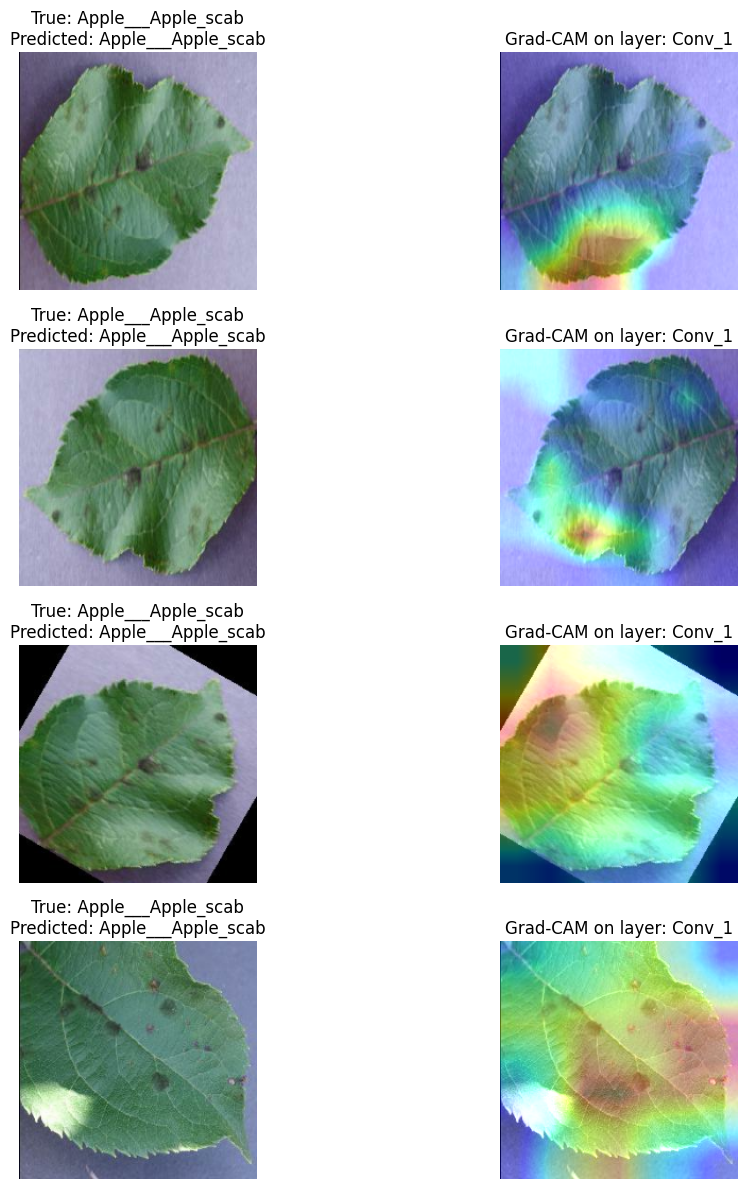

In [187]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# This helper function remains the same as the previous correct version.
def grad_cam(img_array, model, target_conv_layer):
    """
    Computes Grad-CAM by manually reconstructing the model's graph path.
    """
    # 1. Manually preprocess the input image
    img_array_expanded = tf.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(tf.cast(img_array_expanded, dtype=tf.float32))

    # 2. Manually reconstruct the graph path from the base model's input
    base_model = model.get_layer('mobilenetv2_1.00_224')
    
    grad_model_for_outputs = tf.keras.models.Model(
        [base_model.inputs], [base_model.get_layer(target_conv_layer.name).output, base_model.output]
    )
    
    x = grad_model_for_outputs.output[1]
    x = model.get_layer('global_average_pooling2d')(x)
    x = model.get_layer('dropout')(x)
    final_preds = model.get_layer('dense')(x)
    
    final_model = tf.keras.Model(inputs=grad_model_for_outputs.inputs, outputs=[grad_model_for_outputs.output[0], final_preds])

    # 3. Compute gradients
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = final_model(preprocessed_img)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 4. Compute heatmap
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (img_array.shape[0], img_array.shape[1])).numpy()
    heatmap_squeezed = np.squeeze(heatmap_resized)
    heatmap_colored = plt.cm.jet(heatmap_squeezed)[..., :3]

    # 5. Superimpose heatmap on the original image
    superimposed_img = heatmap_colored * 0.4 + (img_array / 255.0)

    return np.clip(superimposed_img, 0, 1), pred_index.numpy()

# --- ADJUSTED FUNCTION ---
# This version now takes 'labels' and 'class_names' to create better titles.
def show_grad_cam(images, labels, model, class_names, target_layer_name):
    """
    Displays the original image with True/Predicted labels and its Grad-CAM overlay.
    """
    try:
        target_layer = model.get_layer('mobilenetv2_1.00_224').get_layer(target_layer_name)
    except ValueError as e:
        print(f"Error: Could not find layer '{target_layer_name}'.")
        return

    plt.figure(figsize=(12, 3 * len(images)))
    for i, img in enumerate(images):
        # Generate the Grad-CAM image and get the predicted class index
        grad_cam_image, predicted_class_index = grad_cam(img, model, target_layer)

        # Get the true and predicted class names for the title
        true_class_name = class_names[labels[i]]
        predicted_class_name = class_names[predicted_class_index]
        
        title_text = f"True: {true_class_name}\nPredicted: {predicted_class_name}"

        # Display Original Image
        ax = plt.subplot(len(images), 2, 2 * i + 1)
        plt.imshow(img.astype("uint8"))
        plt.title(title_text)
        plt.axis("off")

        # Display Grad-CAM Image
        ax = plt.subplot(len(images), 2, 2 * i + 2)
        plt.imshow(grad_cam_image)
        plt.title(f'Grad-CAM on layer: {target_layer_name}')
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# --- FINAL CALL ---
# Use the variables as defined in your notebook.
# [cite_start]The `class_names` list is created in your original code[cite: 57].
# [cite_start]The `images` and `labels` variables are the ones you just selected[cite: 249, 250].
show_grad_cam(images, labels, model, class_names, 'Conv_1')

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 1/4 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 3/4 [00:43<00:10, 10.91s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 4/4 [01:05<00:00, 15.43s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 5it [01:26, 21.52s/it]                       


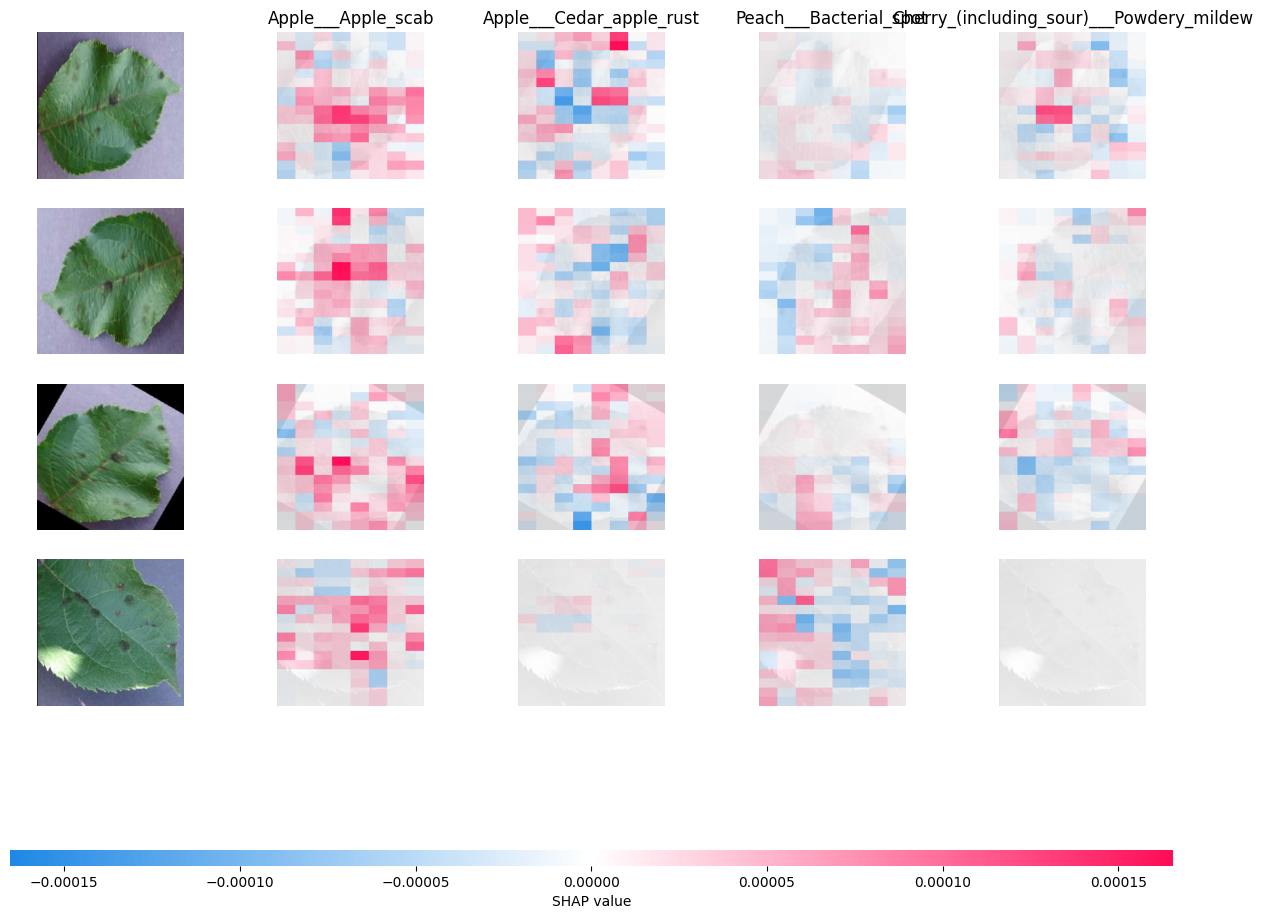

In [185]:
# --- SHAP Explanations ---
masker = shap.maskers.Image("inpaint_telea", images[0].shape) # inpaint_telea blurs the image regions to explain 

explainer = shap.Explainer(model, masker, output_names=class_names)

shap_values = explainer(images, 
                        max_evals=1000,  
                        outputs=shap.Explanation.argsort.flip[:4])

shap.image_plot(shap_values)

In [126]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


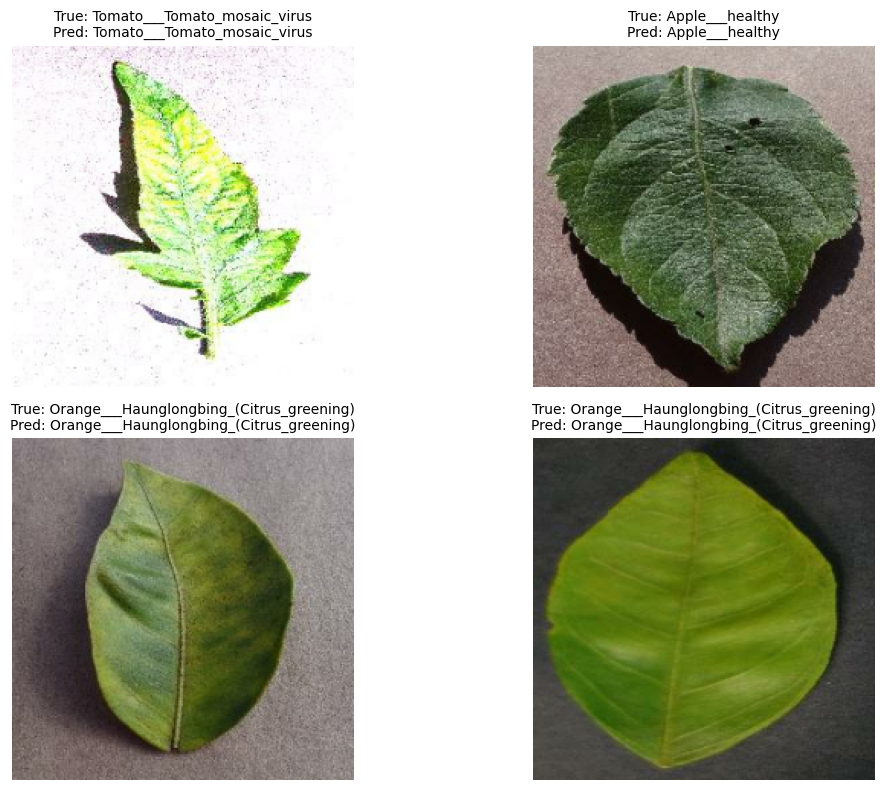

In [134]:
import random
import matplotlib.pyplot as plt
import numpy as np

# If not already defined:
class_names = train_dataset.class_names  # class names from your training set

# Collect all images and labels into arrays
all_images = []
all_labels = []

for images, labels in validation_dataset:
    all_images.extend(images.numpy())
    all_labels.extend(labels.numpy())

all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Select 4 random indices
random_indices = random.sample(range(len(all_images)), 4)

# Set up the plot
plt.figure(figsize=(12, 8))

for i, idx in enumerate(random_indices):
    image = all_images[idx]
    true_label = class_names[all_labels[idx]]

    # Make prediction
    pred = model.predict(np.expand_dims(image, axis=0), verbose=0)
    pred_label = class_names[np.argmax(pred)]

    # Display the image
    plt.subplot(2, 2, i + 1)
    plt.imshow(image.astype("uint8"))  # Adjust depending on preprocessing
    plt.axis('off')
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)

plt.tight_layout()
plt.show()


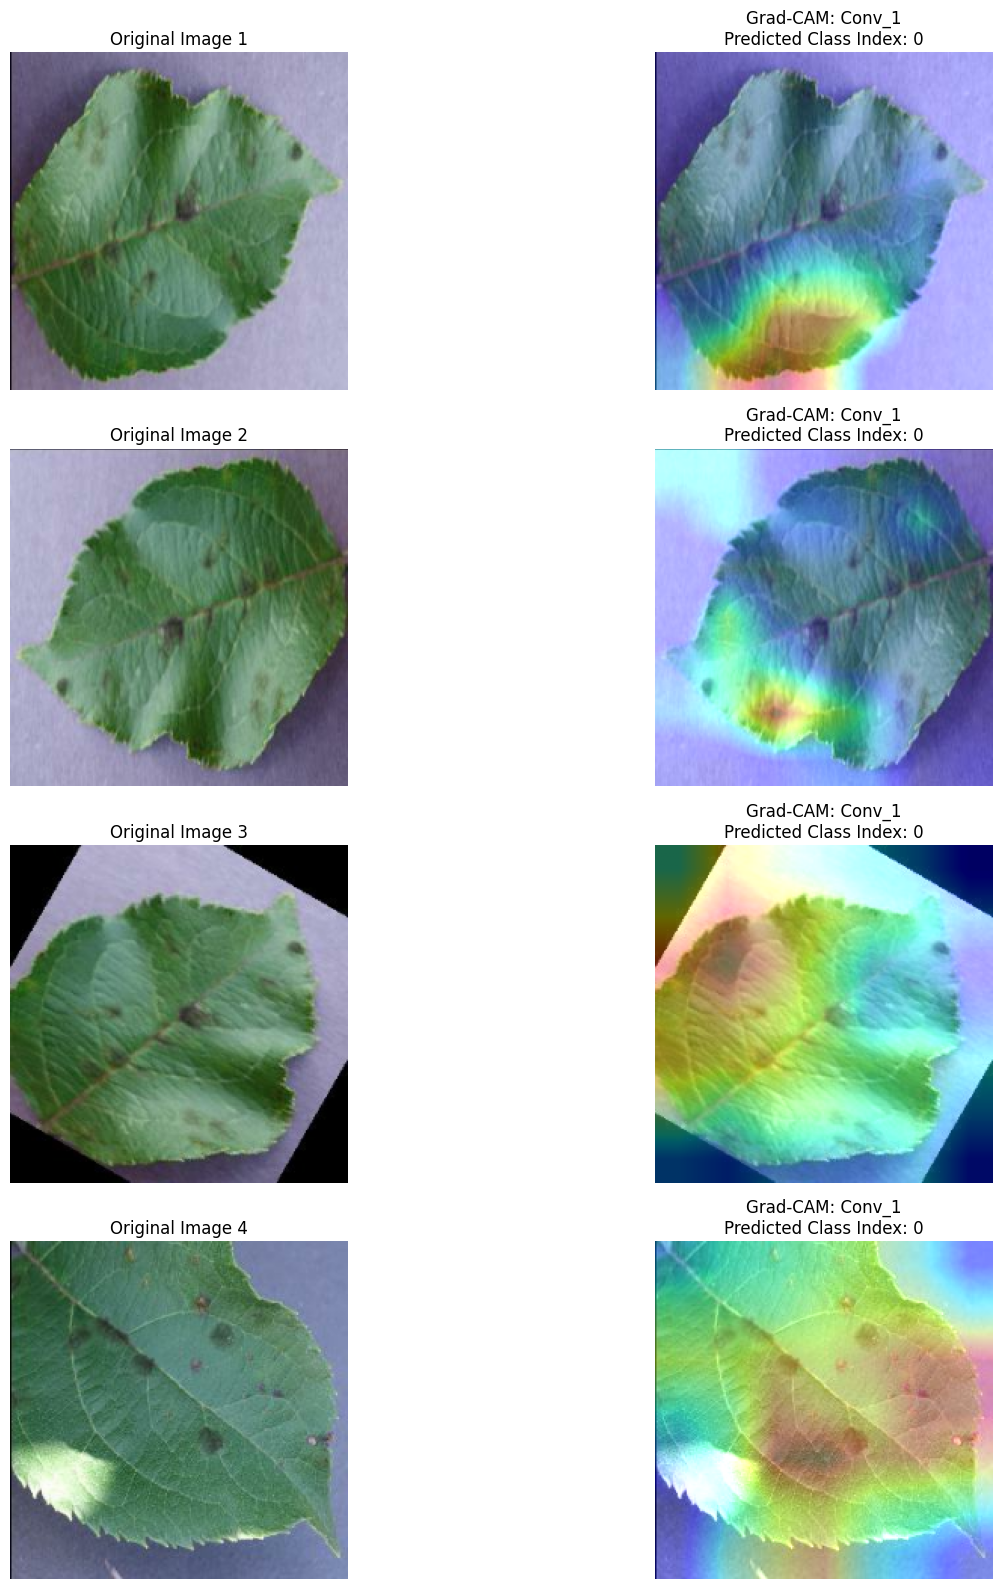

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Your clever grad_cam function with one minor tweak (.numpy())
def grad_cam(img_array, model, target_conv_layer):
    """
    Computes Grad-CAM by manually reconstructing the model's graph path.
    """
    # 1. Manually preprocess the input image
    img_array_expanded = tf.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(tf.cast(img_array_expanded, dtype=tf.float32))

    # 2. Manually reconstruct the graph path from the base model's input
    base_model = model.get_layer('mobilenetv2_1.00_224')
    
    # Rebuild the top of the model to get final predictions
    grad_model = tf.keras.models.Model(
        [base_model.inputs], [base_model.get_layer(target_conv_layer.name).output, base_model.output]
    )
    
    # Get the full model's prediction by passing the output of the grad_model's base through the top layers
    x = grad_model.output[1]
    x = model.get_layer('global_average_pooling2d')(x)
    x = model.get_layer('dropout')(x)
    final_preds = model.get_layer('dense')(x)
    
    final_model = tf.keras.Model(inputs=grad_model.inputs, outputs=[grad_model.output[0], final_preds])


    # 3. Compute gradients
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = final_model(preprocessed_img)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 4. Compute heatmap
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (img_array.shape[0], img_array.shape[1])).numpy()
    heatmap_squeezed = np.squeeze(heatmap_resized)
    heatmap_colored = plt.cm.jet(heatmap_squeezed)[..., :3]

    # 5. Superimpose heatmap on the original image
    superimposed_img = heatmap_colored * 0.4 + (img_array / 255.0)

    # Return the image and the predicted class index
    return np.clip(superimposed_img, 0, 1), pred_index.numpy() # <-- Use .numpy() here

# A corrected version of the calling function
def show_grad_cam(images, model, target_layer_name):
    """
    Displays the original image and its Grad-CAM overlay.
    """
    # Get the specific convolutional layer OBJECT from the model
    try:
        target_layer = model.get_layer('mobilenetv2_1.00_224').get_layer(target_layer_name)
    except ValueError as e:
        print(f"Error: Could not find layer '{target_layer_name}'. Please check the name.")
        print(e)
        return

    plt.figure(figsize=(16, 4 * len(images)))
    for i, img in enumerate(images):
        # Generate the Grad-CAM image
        grad_cam_image, predicted_class_index = grad_cam(img, model, target_layer)

        # Display Original Image
        ax = plt.subplot(len(images), 2, 2 * i + 1)
        plt.imshow(img.astype("uint8"))
        plt.title(f"Original Image {i+1}")
        plt.axis("off")

        # Display Grad-CAM Image
        ax = plt.subplot(len(images), 2, 2 * i + 2)
        plt.imshow(grad_cam_image)
        plt.title(f'Grad-CAM: {target_layer_name}\nPredicted Class Index: {predicted_class_index}')
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# --- FINAL CALL ---
# [cite_start]The 'images' variable is from your notebook [cite: 249]
# Make sure to use the model object you want to inspect (e.g., 'model' or 'cloned_model')
# Provide the NAME of the convolutional layer you want to visualize (e.g., 'Conv_1')
show_grad_cam(images, model, 'Conv_1')